# Weekend Gaps

Reference: Janse van Rensburg, M.; Van Zyl, T. Price Gaps and Volatility: Do Weekend Gaps Tend to Close? J. Risk Financial Manag. 2025, 18, 132. https://doi.org/10.3390/jrfm18030132

The core idea is that the weekend gaps are filled. The paper uses 5-min bars, but I'm legally not allowed to use the data that I have, so I will have to use the daily data from Yahoo Finance and make some assumption.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import yfinance as yf
from multiprocessing import Pool

symbols_dir = "../Symbols.csv"
symbols = pd.read_csv(symbols_dir, index_col=0)
snp = symbols["US-Equity-SNP"].dropna().values.tolist()

In [2]:
# Load the data
def download_data(symbol):

    direc = 'data/'
    os.makedirs(direc, exist_ok=True)

    file_name = os.path.join(direc, symbol + '.csv')
    if not os.path.exists(file_name):

        ticker = yf.Ticker(symbol)
        df = ticker.history(start='2005-01-01', end='2024-5-31')
        if len(df) == 0:
            return
        df.to_csv(file_name)

for i, symbol in enumerate(snp):
    print (f'Loading data for {symbol} ({i+1}/{len(snp)})', end='\r')
    download_data(symbol)

print (f'Loaded data for {len(snp)} companies')

$CTLT: possibly delisted; no price data found  (1d 2005-01-01 -> 2024-5-31) (Yahoo error = "No data found, symbol may be delisted")


$WRK: possibly delisted; no price data found  (1d 2005-01-01 -> 2024-5-31) (Yahoo error = "No data found, symbol may be delisted")


$MRO: possibly delisted; no price data found  (1d 2005-01-01 -> 2024-5-31) (Yahoo error = "No data found, symbol may be delisted")
$WRK: possibly delisted; no price data found  (1d 2005-01-01 -> 2024-5-31) (Yahoo error = "No data found, symbol may be delisted")
$CTLT: possibly delisted; no price data found  (1d 2005-01-01 -> 2024-5-31) (Yahoo error = "No data found, symbol may be delisted")


Loaded data for 494 companies))


In [3]:
def process_data(symbol):

    try:
        df = pd.read_csv(f'data/{symbol}.csv', index_col=0)
        df.index = pd.to_datetime(df.index, utc=True).tz_convert('US/Eastern')

        df = df[['Open', 'High', 'Low', 'Close']].copy()

        df['overnight_gap'] = df['Open'] / df['Close'].shift(1) - 1
        df['intraday_down_move'] = df['Low'] / df['Open'] - 1
        df['intraday_up_move'] = df['High'] / df['Open'] - 1
        df['intraday_return'] = df['Close'] / df['Open'] - 1

        df['closing_price'] = 0.0
        # If the yesterday's close price is in the candle. The closing price
        # is the same as the yesterday's close price. Else, the closing price
        # is the same as the today's Closing price.
        mask_yesterday_close_between_open_and_close = \
            (df['Close'].shift(1) > df['Low']) & \
            (df['Close'].shift(1) < df['High'])
        df.loc[mask_yesterday_close_between_open_and_close, 'closing_price'] = df['Close'].shift(1)
        df.loc[~mask_yesterday_close_between_open_and_close, 'closing_price'] = df['Close']

        df['theoretical_return'] = df['closing_price'] / df['Open'] - 1

    except Exception as e:
        print (f'Error processing data for {symbol}: {e}')
        return None

    return df

df_holder = {}
for symbol in snp:
    df = process_data(symbol)
    if df is None:
        continue

    df_holder[symbol] = df

Error processing data for CTLT: [Errno 2] No such file or directory: 'data/CTLT.csv'
Error processing data for WRK: [Errno 2] No such file or directory: 'data/WRK.csv'
Error processing data for MRO: [Errno 2] No such file or directory: 'data/MRO.csv'
Error processing data for WRK: [Errno 2] No such file or directory: 'data/WRK.csv'
Error processing data for CTLT: [Errno 2] No such file or directory: 'data/CTLT.csv'


# Let's start with some simple regressions

In [4]:
# Weekend gaps on Mondays
holder_for_regression = []
for symbol in df_holder:
  holder_for_regression.append(df_holder[symbol])

df_for_regression = pd.concat(holder_for_regression)

# Filter only the days that are Mondays
df_for_regression = df_for_regression[df_for_regression.index.dayofweek == 0].dropna()

In [5]:
# Get the negative overnight gap and make a regression model with intraday up move
thresholds = [0.01, 0.02, 0.03, 0.04, 0.05]
p_values_list_positive_overnight_gap = []
p_values_list_negative_overnight_gap = []

for threshold in thresholds:
  df_tmp = df_for_regression[df_for_regression['overnight_gap'] > threshold].copy()
  X = df_tmp[['overnight_gap']]
  y = df_tmp['intraday_down_move']
  X = sm.add_constant(X)
  
  model = sm.OLS(y, X).fit()
  p_values_list_positive_overnight_gap.append(
    f"{model.pvalues.iloc[1]:.4f} ({model.tvalues.iloc[1]:.2f})"
  )

for threshold in thresholds:
  df_tmp = df_for_regression[df_for_regression['overnight_gap'] < -threshold].copy()
  
  X = df_tmp[['overnight_gap']]
  X = sm.add_constant(X)
  y = df_tmp['intraday_up_move']
  
  model = sm.OLS(y, X).fit()
  t_stat = model.tvalues.iloc[1]
  p_values_list_negative_overnight_gap.append(
    f"{model.pvalues.iloc[1]:.4f} ({t_stat:.2f})"
  )

df_results = pd.DataFrame(
  {"threshold": thresholds,
   "p_values_positive_overnight_gap": p_values_list_positive_overnight_gap,
   "p_values_negative_overnight_gap": p_values_list_negative_overnight_gap
})

df_results

,threshold,p_values_positive_overnight_gap,p_values_negative_overnight_gap
0,0.01,0.0000 (-61.83),0.0000 (-97.44)
1,0.02,0.0000 (-33.60),0.0000 (-55.88)
2,0.03,0.0000 (-23.68),0.0000 (-34.87)
3,0.04,0.0000 (-19.02),0.0000 (-24.71)
4,0.05,0.0000 (-15.53),0.0000 (-18.44)


# Regressing the intraday return against the overnight return 

# Analysis
The results are really good. Let's see if we can make money with it.

The main question before continuing the analysis is when we are going to enter a position. At auction or after the market opens.

1. **At auction**: It's almost impossible to rank the overnight return before the market open. There will always be problems and errors in the estimations.
1. **After market opens**: We will be late, volatility is high, the orders might not get filled, and slippage is really high. But that's what we can do

Let's see if we can simulate this strategy

In [35]:
df_over_night_gap = []
df_theoretical_return = []
for symbol in df_holder:
    df_over_night_gap.append(df_holder[symbol]['overnight_gap'])
    df_theoretical_return.append(df_holder[symbol]['theoretical_return'])

cols = list(df_holder.keys())

df_over_night_gap = pd.concat(df_over_night_gap, axis=1)
df_over_night_gap.columns = cols

df_theoretical_return = pd.concat(df_theoretical_return, axis=1)
df_theoretical_return.columns = cols

N = 10
top_N_mask = df_over_night_gap.rank(axis=1, method='dense', ascending=False) <= N
bottom_N_mask = df_over_night_gap.rank(axis=1, method='dense', ascending=True) <= N

short_df = df_theoretical_return.mask(~top_N_mask, np.nan) * -1
long_df = df_theoretical_return.mask(~bottom_N_mask, np.nan) * 1

portfolio_return = pd.DataFrame(index=df_theoretical_return.index, columns=df_theoretical_return.columns)
portfolio_return.iloc[:, :] = np.nan

portfolio_return[top_N_mask] = short_df[top_N_mask]
portfolio_return[bottom_N_mask] = long_df[bottom_N_mask]

# Get the average, over axis 1, ignoring the NaN
portfolio_return = portfolio_return.mean(axis=1)

In [36]:
# Get the market data
download_data('^GSPC')
snp = pd.read_csv('./data/^GSPC.csv', index_col=0)
market_return = snp['Close'].pct_change()

market_return.index = pd.to_datetime(market_return.index, utc=True).tz_convert('US/Eastern')

Sharpe: 4.02, ADR: 0.0023 Vol: 0.01
Beta: 0.01


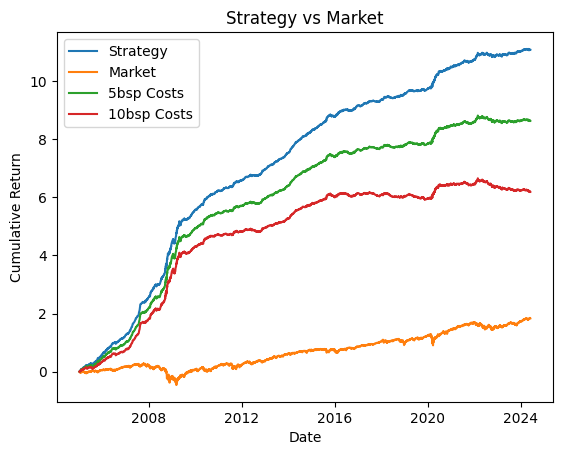

In [44]:
adr = portfolio_return.mean()
std = portfolio_return.std()
sharpe = adr / std * np.sqrt(252)
print(f'Sharpe: {sharpe:.2f}, ADR: {adr:.4f} Vol: {std:.2f}')

df_tmp = pd.concat([market_return, portfolio_return], axis = 1)
df_tmp.columns = ['Market', 'Strategy']

df_tmp['Market'] = df_tmp['Market'].astype(float)
df_tmp['Strategy'] = df_tmp['Strategy'].astype(float)

df_tmp.dropna(inplace=True)

X = df_tmp[['Market']]
X = sm.add_constant(X)
y = df_tmp['Strategy']

model = sm.OLS(y, X)
result = model.fit()

# Get the beta
beta = result.params.iloc[1]
print(f'Beta: {beta:.2f}')

plt.plot(df_tmp['Strategy'].cumsum(), label='Strategy')
plt.plot(df_tmp['Market'].cumsum(), label='Market')
plt.plot((df_tmp['Strategy'] - 0.0005).cumsum(), label='5bsp Costs')
plt.plot((df_tmp['Strategy'] - 0.0010).cumsum(), label='10bsp Costs')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Strategy vs Market')
plt.legend()
plt.show()


# Performance since 2015

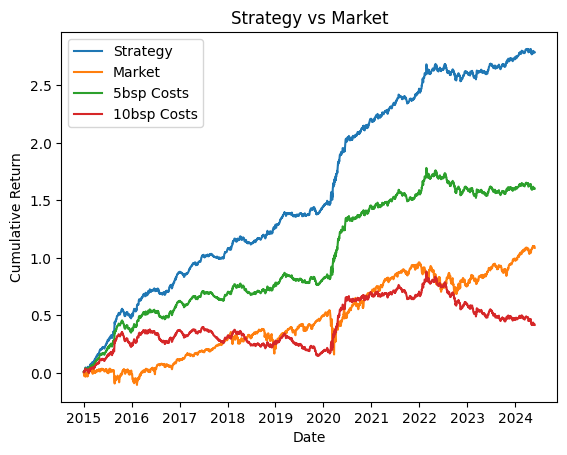

In [46]:
df_after_2015 = df_tmp[df_tmp.index >= '2015-01-01']

plt.plot(df_after_2015['Strategy'].cumsum(), label='Strategy')
plt.plot(df_after_2015['Market'].cumsum(), label='Market')
plt.plot((df_after_2015['Strategy'] - 0.0005).cumsum(), label='5bsp Costs')
plt.plot((df_after_2015['Strategy'] - 0.0010).cumsum(), label='10bsp Costs')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Strategy vs Market')
plt.legend()
plt.show()

# Final remarks:
1. This strategy is only good if you can execute it with no costs.
1. Even a 5 bsp, transaction cost will ruin the performance of this strategy.
1. This strategy is not that different from any other cross sectional strategies. It will work when volatility is high.
1. The original paper tried it with other instruments. It might affect the results, but I highly doubt it.
1. Definitely good enough for academic journals. But far far from even considering it for implementation.